# 01. Data Exploration and Analysis

## 0. Setup and Imports

### 0.1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter

import nltk, os, glob, re, string

# Set up plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
%matplotlib inline

## 1. Data Loading

### 1.1 Combine All Data with Confidence Rates and Save

Download and load the Financial PhraseBank dataset
- Dataset URL: https://www.researchgate.net/publication/251231107_FinancialPhraseBank-v10

In [2]:
# File paths for all agreement levels
file_50_agree = '../data/raw/Sentences_50Agree.txt'
file_66_agree = '../data/raw/Sentences_66Agree.txt'
file_75_agree = '../data/raw/Sentences_75Agree.txt'
file_100_agree = '../data/raw/Sentences_100Agree.txt'

# Temporary list to hold data
data_list = []

# Helper: Extract confidence from filename
def extract_confidence(file_path):
    fname = os.path.basename(file_path).lower()
    if '100agree' in fname:
        return 1.00
    elif '75agree' in fname:
        return 0.75
    elif '66agree' in fname:
        return 0.66
    elif '50agree' in fname:
        return 0.50
    else:
        return None  # Unknown confidence

# Load files
for file_path in [file_50_agree, file_66_agree, file_75_agree, file_100_agree]:
    confidence = extract_confidence(file_path)
    if confidence is None:
        print(f"⚠️  Could not determine confidence for: {file_path}")
        continue
    if os.path.exists(file_path):
        print(f"Loading {file_path}...")
        loaded_count = 0
        with open(file_path, 'r', encoding='latin1') as file:
            for line in file:
                line = line.strip()
                if line and '@' in line:
                    parts = line.split('@')
                    if len(parts) == 2:
                        text, sentiment = parts
                        data_list.append({
                            'text': text.strip(),
                            'sentiment': sentiment.strip(),
                            'confidence': confidence
                        })
                        loaded_count += 1
        print(f"  Loaded {loaded_count} sentences with {int(confidence*100)}% agreement")
    else:
        print(f"⚠️  File not found: {file_path}")

# Create DataFrame
if data_list:
    df = pd.DataFrame(data_list)
    
    # Save the combined dataset
    output_path = '../data/processed/financial_phrasebank_all_confidence.csv'
    df.to_csv(output_path, index=False)
    print(f"\n💾 Dataset saved to: {output_path}")
else:
    print("❌ No data loaded. Please check if the files exist and have correct format.")

Loading ../data/raw/Sentences_50Agree.txt...
  Loaded 4846 sentences with 50% agreement
Loading ../data/raw/Sentences_66Agree.txt...
  Loaded 4217 sentences with 66% agreement
Loading ../data/raw/Sentences_75Agree.txt...
  Loaded 3453 sentences with 75% agreement
Loading ../data/raw/Sentences_100Agree.txt...
  Loaded 2264 sentences with 100% agreement

💾 Dataset saved to: ../data/processed/financial_phrasebank_all_confidence.csv


## 2. Basic Data Exploration

### 2.1 Dataframe Head Sample

In [3]:
df.head()

,text,sentiment,confidence
0,"According to Gran , the company has no plans t...",neutral,0.5
1,Technopolis plans to develop in stages an area...,neutral,0.5
2,The international electronic industry company ...,negative,0.5
3,With the new production plant the company woul...,positive,0.5
4,According to the company 's updated strategy f...,positive,0.5


### 2.2 Data types

In [4]:
print(f"Data types of the database (column, data type): \n{df.dtypes}")

Data types of the database (column, data type): 
text           object
sentiment      object
confidence    float64
dtype: object


### 2.3 Missing Values

In [5]:
df.isnull().sum()

text          0
sentiment     0
confidence    0
dtype: int64

### 2.4 Duplicate Texts

In [6]:
df['text'].duplicated().sum()  # Check for duplicate texts

np.int64(9942)

In [7]:
# Remove duplicates, keeping only the highest confidence version
df = df.sort_values('confidence', ascending=False).drop_duplicates(subset='text', keep='first').reset_index(drop=True)
print(f"After removing lower-confidence duplicates, shape: {df.shape}")

After removing lower-confidence duplicates, shape: (4838, 3)


In [8]:
df['text'].duplicated().sum()  # Check again for duplicates

np.int64(0)

In [9]:
df['text'].count()  # Print the number of unique texts

np.int64(4838)

## 3. Data Quality Assessment

### 3.1 Identify Very Short or Very Long Texts

In [ ]:
# Text length distribution
df['text_length_chars'] = df['text'].str.len()
df['text_length_words'] = df['text'].str.split().str.len()

# Print number of texts with less than 10 words and more than 100 words
num_short = (df['text'].str.split().str.len() < 10).sum()
num_long = (df['text'].str.split().str.len() > 100).sum()
print(f"Number of texts with less than 10 words: {num_short}")
print(f"Number of texts with more than 100 words: {num_long}")

Number of texts with less than 10 words: 220
Number of texts with more than 100 words: 0


In [15]:
# Filter out texts with less than 10 words or more than 100 words
df = df[df['text'].str.split().str.len().between(10, 100)].reset_index(drop=True)

In [16]:
# Print number of texts with less than 10 words and more than 100 words
num_short = (df['text'].str.split().str.len() < 10).sum()
num_long = (df['text'].str.split().str.len() > 100).sum()
print(f"Number of texts with less than 10 words: {num_short}")
print(f"Number of texts with more than 100 words: {num_long}")
print(f"DataFrame shape {df.shape}")  # Print the shape of the DataFrame after filtering

Number of texts with less than 10 words: 0
Number of texts with more than 100 words: 0
DataFrame shape (4618, 5)


### 3.2 Text Sterilisation

In [17]:
# ---------------------------------------------------------------------------- #
#                            CHARACTERS TO PRESERVE                            #
# ---------------------------------------------------------------------------- #

# ------------- DEFINE FINANCIAL AND CURRENCY SYMBOLS TO PRESERVE ------------ #
financial_symbols = {
    # Currency symbols
    '$', '€', '£', '¥', '₹', '₽', '₩', '₪', '₡', '₨', '₦', '₵', '₴', '₸', '₼',
    # Financial notation
    '%', '+', '-', '=', '(', ')', '.', ',', ';', ':', 
    # Quotation marks (often used in financial context)
    '"', "'", '!', '?'
    # Add ampersand since we handle it in cleaning
    '&'
}

# --------------------- STANDARD ALPHANUMERIC CHARACTERS --------------------- #
standard_chars = set(string.ascii_letters + string.digits + ' ')

# ------------------------- ALL ACCEPTABLE CHARACTERS ------------------------ #
acceptable_chars = financial_symbols | standard_chars


# ---------------------------------------------------------------------------- #
#                                   FUNCTIONS                                  #
# ---------------------------------------------------------------------------- #

# Identifies problematic characters
def has_problematic_chars(text):
    text_chars = set(text)
    problematic = text_chars - acceptable_chars
    return len(problematic) > 0

# Rules to clean text while preserving necessary symbols like financial symbols
def clean_text(text):
    """Clean text while preserving financial symbols"""

    # ------------------ REMOVE ENCODING ARTIFACTS AND NON-ASCII ----------------- #
    encoding_artifacts = [
        # Unicode replacement characters
        '�', '\ufffd',
        # Null and control characters  
        '\x00', '\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08',
        '\x0b', '\x0c', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14',
        '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1c', '\x1d',
        '\x1e', '\x1f', '\x7f',
        # Common encoding artifacts (literal strings that shouldn't be there)
        '\\x', '\\u', '\\n', '\\t', '\\r',
        # Byte order marks
        '\ufeff', '\ufffe'
    ]
    for artifact in encoding_artifacts:
        text = text.replace(artifact, ' ')
    # ---------------------------------------------------------------------------- #

    # ------------------------- REMOVE URLS AND WEB LINKS ------------------------ #
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'[a-zA-Z0-9-]+\.(com|org|net|gov|edu|co\.uk|de|fr|it|es)', '', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    # ---------------------------------------------------------------------------- #

    # ---------------------- EXPAND FINANCIAL ABBREVIATIONS ---------------------- #
    text = re.sub(r'\b(\d+(?:\.\d+)?)\s*mn\b', r'\1 million', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(\d+(?:\.\d+)?)\s*bn\b', r'\1 billion', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(\d+(?:\.\d+)?)\s*tn\b', r'\1 trillion', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(\d+(?:\.\d+)?)\s*k\b', r'\1 thousand', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(\d+(?:\.\d+)?)\s*M\b(?!\w)', r'\1 million', text)
    text = re.sub(r'\b(\d+(?:\.\d+)?)\s*B\b(?!\w)', r'\1 billion', text)
    # ---------------------------------------------------------------------------- #

    # ------------------------ SYMBOL-TO-TEXT REPLACEMENTS ----------------------- #
    text = re.sub(r'\s*&\s*', ' and ', text)
    text = re.sub(r'\bpct\b', 'percent', text, flags=re.IGNORECASE)
    text = re.sub(r'\bq1\b', 'first quarter', text, flags=re.IGNORECASE)
    text = re.sub(r'\bq2\b', 'second quarter', text, flags=re.IGNORECASE)
    text = re.sub(r'\bq3\b', 'third quarter', text, flags=re.IGNORECASE)
    text = re.sub(r'\bq4\b', 'fourth quarter', text, flags=re.IGNORECASE)
    text = re.sub(r'\byoy\b', 'year over year', text, flags=re.IGNORECASE)
    text = re.sub(r'\bqoq\b', 'quarter over quarter', text, flags=re.IGNORECASE)
    # ---------------------------------------------------------------------------- #

    # -------- REMOVE MULTIPLE CONSECUTIVE PUNCTUATION MARKS (KEEP MAX 2) -------- #
    text = re.sub(r'([.]{3,})', '...', text)  # Keep ellipsis
    text = re.sub(r'([!]{2,})', '!', text)    # Reduce multiple exclamations
    text = re.sub(r'([?]{2,})', '?', text)    # Reduce multiple questions
    text = re.sub(r'([,]{2,})', ',', text)    # Remove multiple commas
    # ---------------------------------------------------------------------------- #
    
    # ---------------------- FIX SPACING AROUND PUNCTUATION ---------------------- #
    text = re.sub(r'\s+([,.;:!?%])', r'\1', text)            # Remove space before punctuation
    text = re.sub(r'([,.;:!?%])(?=[A-Za-z])', r'\1 ', text)  # Add space after punctuation if needed
    text = re.sub(r'([,.;:!?%])\s+', r'\1 ', text)           # Normalize multiple spaces after punctuation
    # ---------------------------------------------------------------------------- #
        
    # ------------------- REMOVE PROBLEMATIC SPECIAL CHARACTERS ------------------ #
    cleaned_chars = []
    for char in text:
        if char in acceptable_chars:
            cleaned_chars.append(char)
        else:
            # Replace with space to avoid word concatenation
            cleaned_chars.append(' ')
    
    text = ''.join(cleaned_chars)
    # ---------------------------------------------------------------------------- #
    
    # ------------------------- CLEAN UP MULTIPLE SPACES ------------------------- #
    text = re.sub(r'\s+', ' ', text)
    
    # -------------------- REMOVE LEADING/TRAILING WHITESPACE -------------------- #
    text = text.strip()
    
    return text

# ------------------------- SEARCH FOR TEXT TO CLEAN ------------------------- #
# Check for URLs/links
url_pattern = r'http[s]?://|www\.|\.com|\.org|\.net|\.gov|\.edu'
has_urls = df['text'].str.contains(url_pattern, case=False)
print(f"Texts with URLs/web content: {has_urls.sum()}")

# Check for email addresses
email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
has_emails = df['text'].str.contains(email_pattern, case=False)
print(f"Texts with email addresses: {has_emails.sum()}")

# Check for financial symbols (these should be preserved)
financial_pattern = r'[\$€£¥%]'
has_financial = df['text'].str.contains(financial_pattern)
print(f"Texts with financial symbols: {has_financial.sum()}")  
# ---------------------------------------------------------------------------- #

# ------------------------------ APPLY CLEANING ------------------------------ #
print("\n=== APPLYING CLEANING ===")
df['text_original'] = df['text'].copy()  # Backup original
df['text'] = df['text'].apply(clean_text)
# ---------------------------------------------------------------------------- #

# -------------------------- PROBLEMATIC CHARACTERS -------------------------- #
# Check for problematic characters
df['has_problematic_chars'] = df['text'].apply(has_problematic_chars)
problematic_count = df['has_problematic_chars'].sum()
print(f"Texts with problematic special characters: {problematic_count}")  

# Show examples of problematic content
if has_urls.sum() > 0:
    print("\nExamples with URLs:")
    for text in df[has_urls]['text'].head(3):
        print(f"  {text}")

if problematic_count > 0:
    print("\nExamples with problematic characters:")
    for text in df[df['has_problematic_chars']]['text'].head(3):
        problematic = set(text) - acceptable_chars
        print(f"  Text: {text[:80]}...")
        print(f"  Problematic chars: {problematic}")
# ---------------------------------------------------------------------------- #

# ------------------------------ AFTER CLEANING ------------------------------ #
print("\n=== AFTER CLEANING ===")
has_urls_after = df['text'].str.contains(url_pattern, case=False)
print(f"Texts with URLs after cleaning: {has_urls_after.sum()}")

has_financial_after = df['text'].str.contains(financial_pattern)
print(f"Texts with financial symbols after cleaning: {has_financial_after.sum()}")

df['has_problematic_chars_after'] = df['text'].apply(has_problematic_chars)
problematic_after = df['has_problematic_chars_after'].sum()
print(f"Texts with problematic characters after cleaning: {problematic_after}")

# Show examples of cleaning
print("\n=== CLEANING EXAMPLES ===")
cleaned_examples = df[df['text_original'] != df['text']].head(5)
for idx, row in cleaned_examples.iterrows():
    print(f"Original:  {row['text_original']}")
    print(f"Cleaned:   {row['text']}")
    print()
# ---------------------------------------------------------------------------- #

# Remove temporary columns
df = df.drop(['has_problematic_chars', 'has_problematic_chars_after', 'text_original'], axis=1)

print(f"Final dataset shape: {df.shape}")

Texts with URLs/web content: 35
Texts with email addresses: 0
Texts with financial symbols: 486

=== APPLYING CLEANING ===
Texts with problematic special characters: 0

Examples with URLs:
  For 24-hour news, try ICIS news Click trial '', then ICIS news
  The terms and conditions of the Stock Option Scheme 2008 are available on the Company 's internet pages.
  The webcast may be followed online on the company website at.

=== AFTER CLEANING ===
Texts with URLs after cleaning: 0
Texts with financial symbols after cleaning: 486
Texts with problematic characters after cleaning: 0

=== CLEANING EXAMPLES ===
Original:  In the building and home improvement trade , net sales totalled EUR 1,173 mn , down from EUR 1,566 mn a year earlier .
Cleaned:   In the building and home improvement trade, net sales totalled EUR 1,173 million, down from EUR 1,566 million a year earlier.

Original:  Finnish meat company Atria can no longer promise a sufficient amount of domestic beef to its customers .
Clean

### 3.3 Print Clean Text

In [19]:
for i, text in enumerate(df['text'].head()):
    print(f"\nExample {i+1}:")
    print(f"Text: {text}")
    print(f"Sentiment: {df.iloc[i]['sentiment']}")
    print(f"Confidence: {df.iloc[i]['confidence']}")
    print("-" * 80)


Example 1:
Text: In the building and home improvement trade, net sales totalled EUR 1,173 million, down from EUR 1,566 million a year earlier.
Sentiment: negative
Confidence: 1.0
--------------------------------------------------------------------------------

Example 2:
Text: Finnish meat company Atria can no longer promise a sufficient amount of domestic beef to its customers.
Sentiment: negative
Confidence: 1.0
--------------------------------------------------------------------------------

Example 3:
Text: Sales in Finland decreased by 10.5% in January, while sales outside Finland dropped by 17%.
Sentiment: negative
Confidence: 1.0
--------------------------------------------------------------------------------

Example 4:
Text: Operating profit fell to EUR 35.4 million from EUR 68.8 million in 2007, including vessel sales gain of EUR 12.3 million.
Sentiment: negative
Confidence: 1.0
--------------------------------------------------------------------------------

Example 5:
Text

## 4. Sentiment Distribution Analysis

### 4.1 Sentiment Distribution Analysis

Sentiment distribution:


Text(0, 0.5, '')

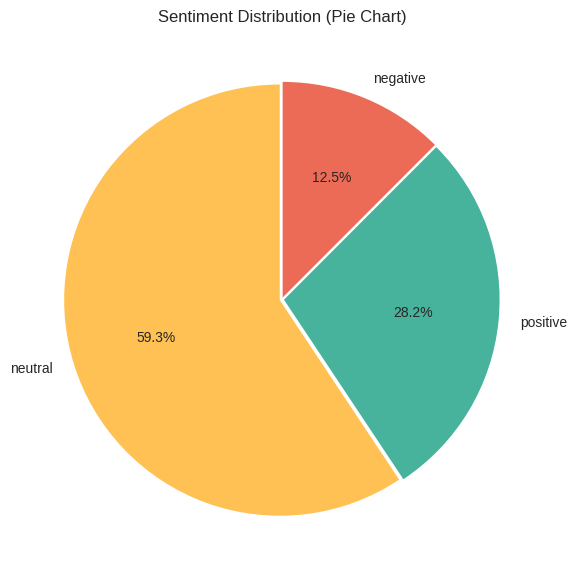

In [ ]:
# -------------------------- SENTIMENT DISTRIBUTION -------------------------- #
print("Sentiment distribution:")
df['sentiment'].value_counts()
# ---------------------------------------------------------------------------- #

# ------------------- PIE CHART FOR SENTIMENT DISTRIBUTION ------------------- #
plt.figure(figsize=(7, 7))
df['sentiment'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['#FFC154', '#47B39C', '#EC6B56'],
    startangle=90,
    explode=[0.01, 0.01, 0.01]
)
plt.title('Sentiment Distribution (Pie Chart)')
plt.ylabel('')
# ---------------------------------------------------------------------------- #

## 5. Text Characteristics Analysis

### 5.1 Text Length Distribution

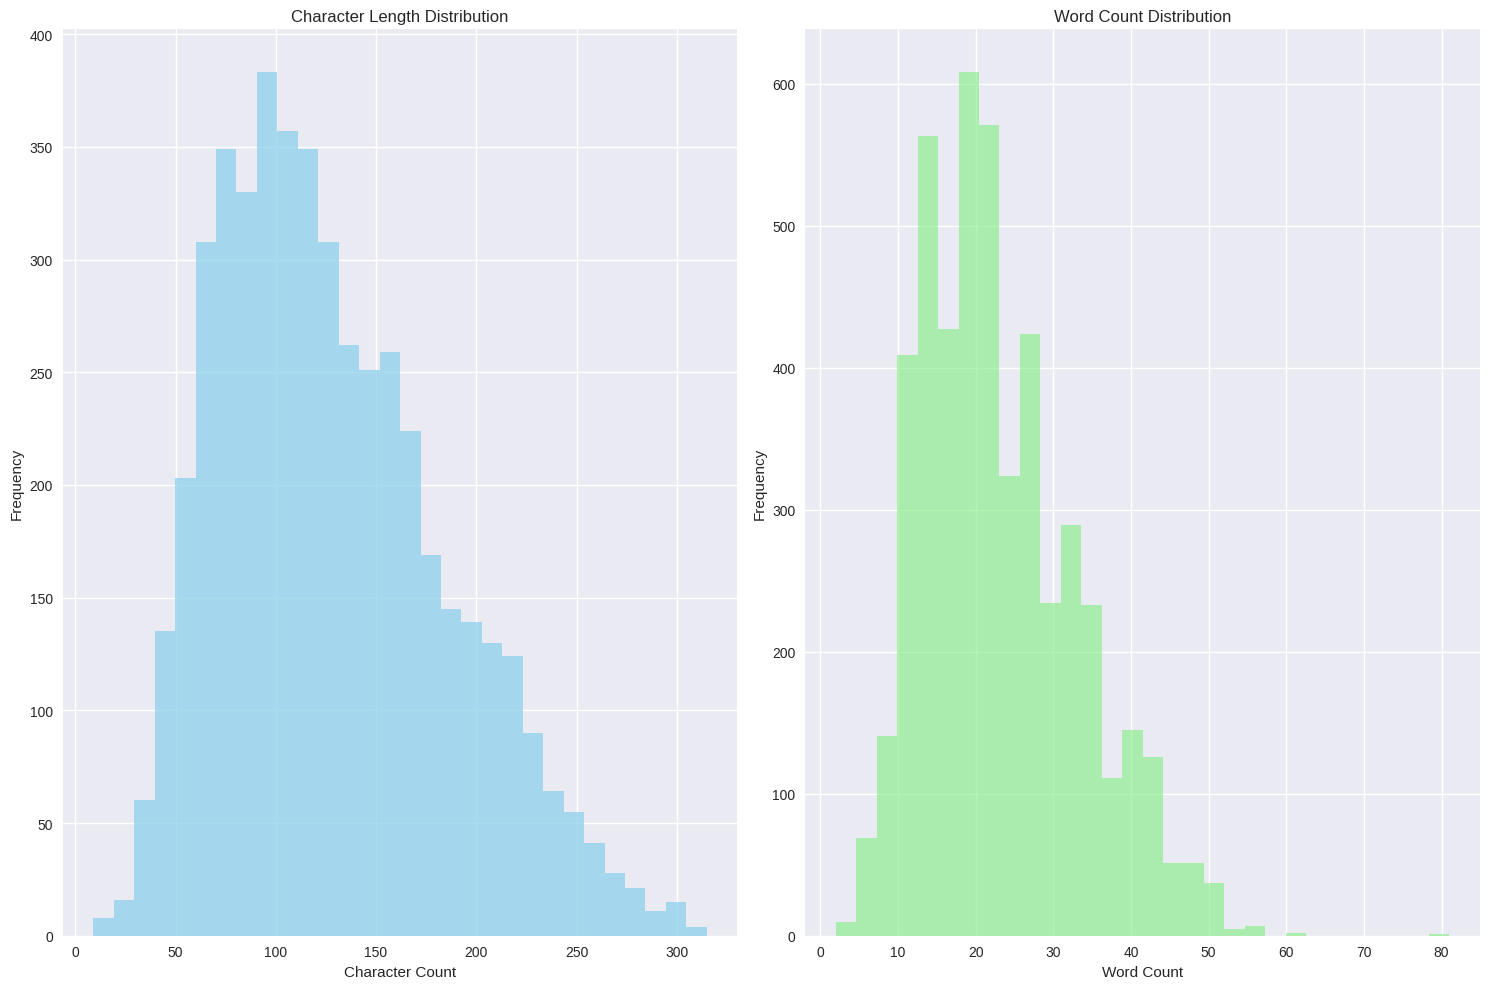

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Character length histogram
axes[0].hist(df['text_length_chars'], bins=30, alpha=0.7, color='skyblue')
axes[0].set_title('Character Length Distribution')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')

# Word count histogram
axes[1].hist(df['text_length_words'], bins=30, alpha=0.7, color='lightgreen')
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 5.2 Most Common Words For Sentiment Classes

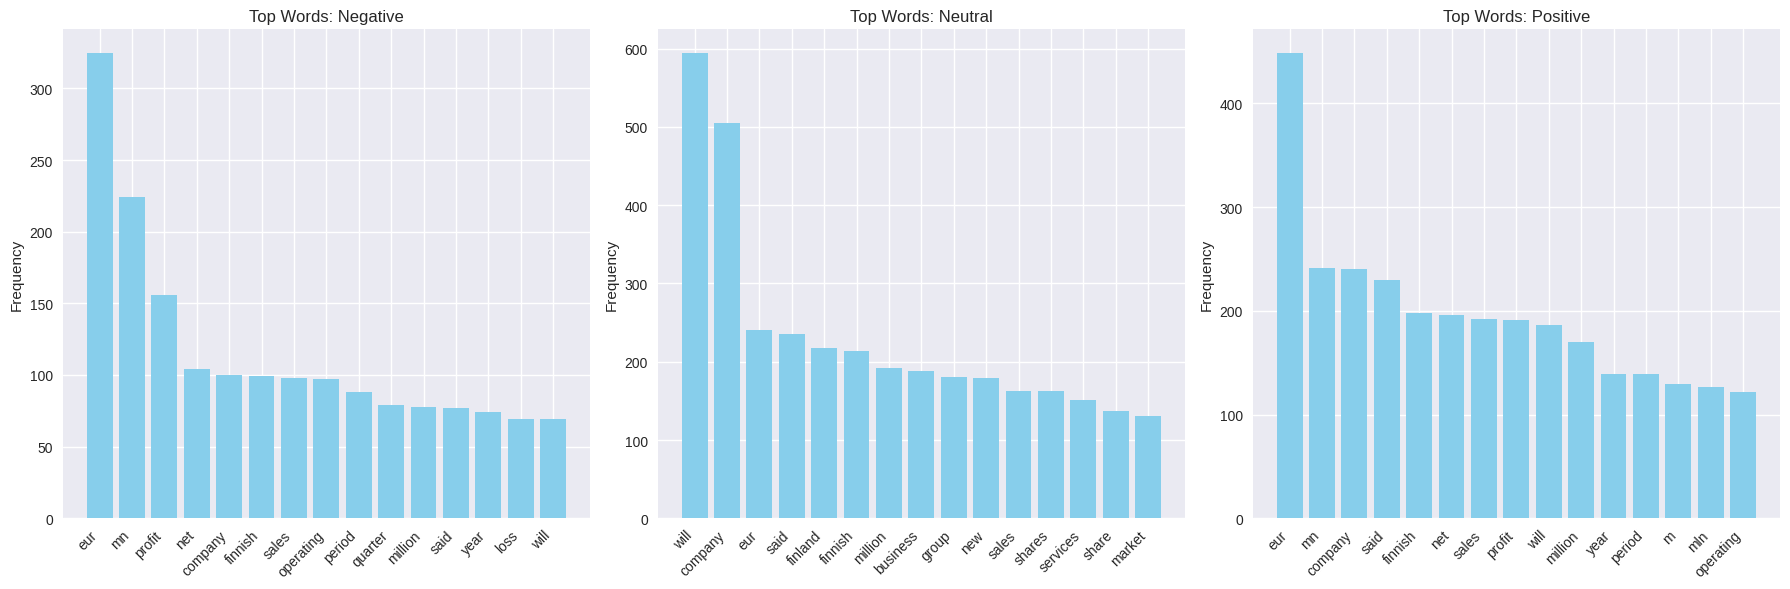

In [12]:
from wordcloud import STOPWORDS

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sentiments = df['sentiment'].unique()
for i, sentiment in enumerate(sentiments):
    words = df[df['sentiment'] == sentiment]['text'].str.lower().str.split().sum()
    filtered_words = [w for w in words if w not in STOPWORDS and w.isalpha()]
    common_words = Counter(filtered_words).most_common(15)
    labels, values = zip(*common_words)
    axes[i].bar(labels, values, color='skyblue')
    axes[i].set_title(f"Top Words: {sentiment.capitalize()}")
    axes[i].set_xticks(range(len(labels)))
    axes[i].set_xticklabels(labels, rotation=45, ha='right')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

### 5.3 Average Text Length by Sentiment

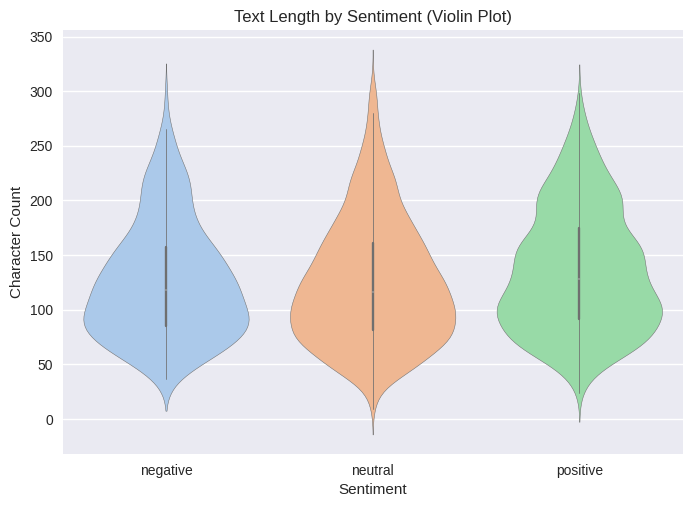

In [13]:
sns.violinplot(x='sentiment', y='text_length_chars', data=df, hue='sentiment', palette='pastel', legend=False)
plt.title('Text Length by Sentiment (Violin Plot)')
plt.xlabel('Sentiment')
plt.ylabel('Character Count')
plt.show()

### 5.3 Remove Unnecessary Text Statistics Columns

In [18]:
df = df.drop(['text_length_chars', 'text_length_words'], axis=1)

## Financial Domain Analysis

In [20]:
# TODO: Analyze financial domain-specific characteristics
# 1. Extract financial terms and entities
# 2. Analyze sentiment patterns around financial keywords
# 3. Identify common financial phrases
# 4. Look for temporal patterns if dates are available

# Your code here

## Key Insights and Conclusions

**Your Task**: Summarize your findings and their implications for model development

### Questions to answer:
1. What is the distribution of sentiment classes?
2. Are there any data quality issues to address?
3. What are the key characteristics of financial text?
4. What preprocessing steps will be needed?
5. What challenges do you anticipate for the model?

### Next Steps:
- Data preprocessing strategy
- Model selection considerations
- Evaluation metrics planning

## 💡 Implementation Hints:

### Data Loading:
```python
# If you don't have the dataset yet, create sample data:
sample_data = {
    'text': [
        'Company profits exceeded expectations this quarter',
        'Stock prices fell sharply amid market uncertainty',
        'Revenue remained stable compared to last year'
    ],
    'sentiment': ['positive', 'negative', 'neutral']
}
df = pd.DataFrame(sample_data)
```

### Text Analysis:
```python
# Text length analysis
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()
```

### Visualization:
```python
# Sentiment distribution
plt.figure(figsize=(8, 6))
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.show()
```